
## Traffic Sign OOD Detection

In [1]:
# install dependencies
# %pip install git+https://github.com/mvaldenegro/keras-uncertainty
# %pip install tensorflow_probability

---
## Step 0: Load The Data

In [2]:
# Load pickled data(dataset is the German Traffic Sign Recognition Benchmark (GTSRB) dataset)
# a preprocessed version is available under https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip
import pickle

training_file = "traffic-signs-data/train.p"
validation_file= "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode="rb") as f:
    train = pickle.load(f)
with open(validation_file, mode="rb") as f:
    valid = pickle.load(f)
with open(testing_file, mode="rb") as f:
    test = pickle.load(f)
    
X_train, y_train, X_train_size, X_train_coords = train["features"], train["labels"], train["sizes"], train["coords"]
X_valid, y_valid, X_valid_size, X_valid_coords = valid["features"], valid["labels"], valid["sizes"], valid["coords"]
X_test, y_test, X_test_size, X_test_coords = test["features"], test["labels"], test["sizes"], test["coords"]

## Step 1: Basic Summary of the Data Set 

In [3]:
import numpy as np

n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train[0].shape
n_classes = np.unique(np.concatenate([y_train, y_valid, y_test])).size

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### visualization of the dataset

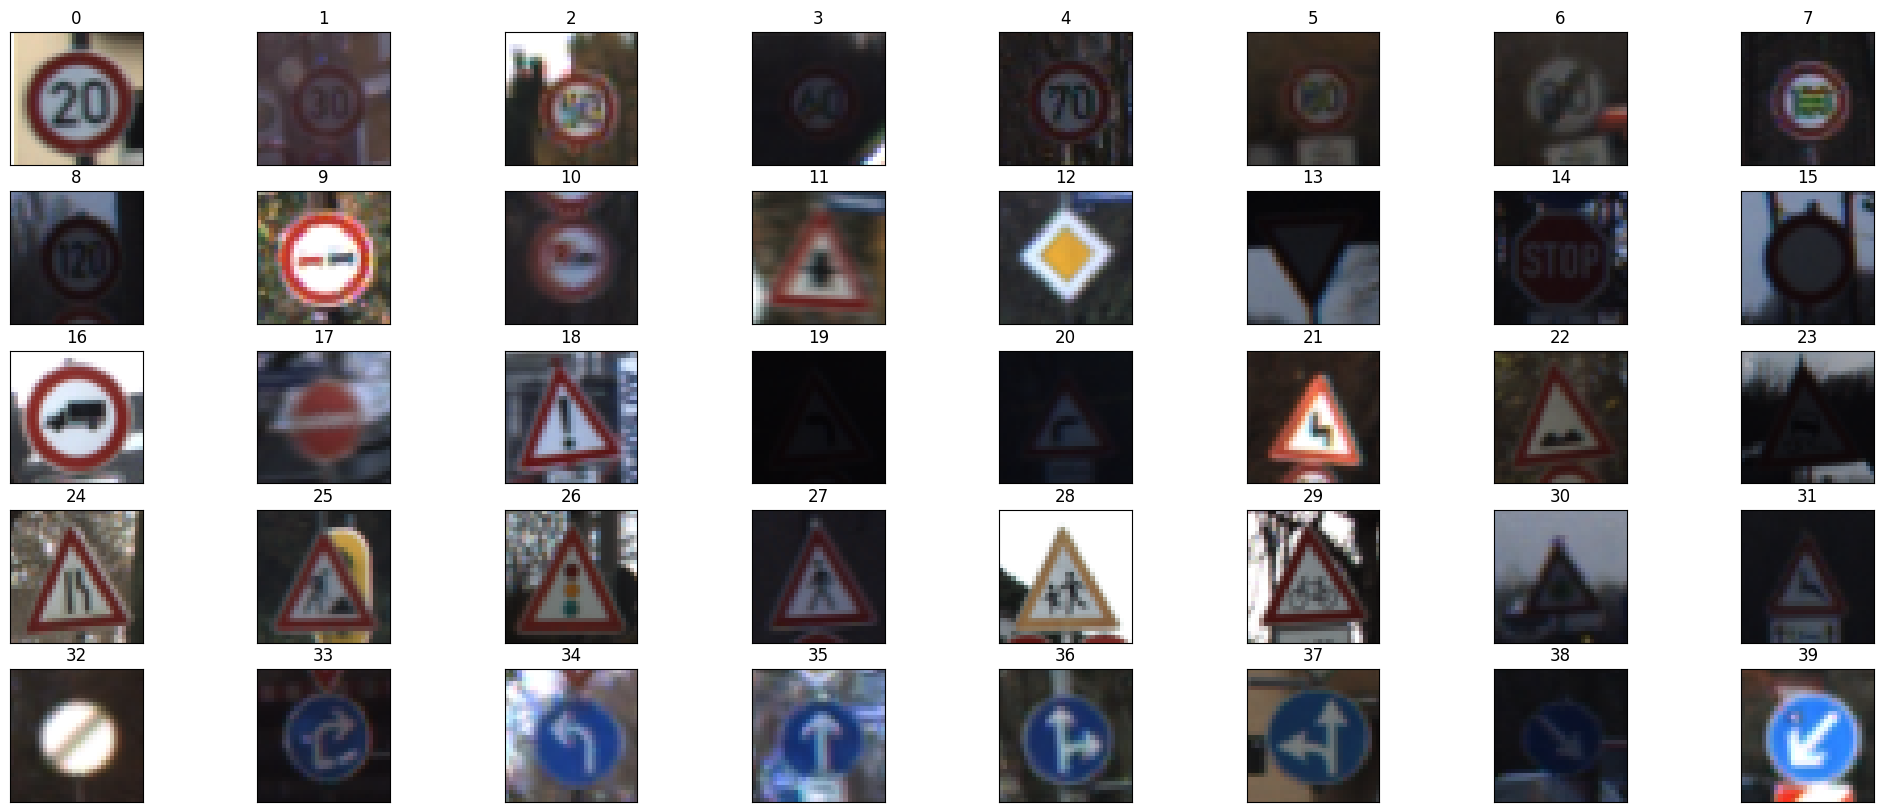

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax_array = plt.subplots(5, 8, figsize=(25, 10))
for i, ax in enumerate(ax_array.flatten()):
    class_id = i
    X_train_in_class = X_train[y_train==class_id]
    ax.imshow(X_train_in_class[i])
    ax.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
    ax.set_title(class_id)
fig.savefig("./docs/traffic_signs.jpg", dpi=fig.dpi)
plt.show()

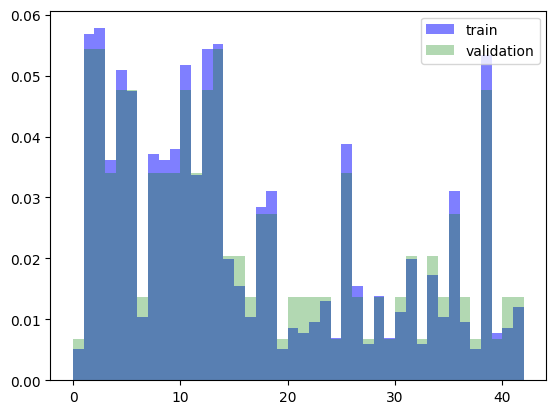

In [5]:
import matplotlib.pyplot as plt

weights_train = np.ones(len(y_train)) / len(y_train)
weights_valid = np.ones(len(y_valid)) / len(y_valid)
bins = range(43)
plt.hist(y_train, bins=bins, weights=weights_train, alpha=0.5, label="train", color="blue")
plt.hist(y_valid, bins=bins, weights=weights_valid, alpha=0.3, label="validation", color="green")
plt.legend(loc="upper right")
plt.savefig("./docs/traffic_signs_classes.jpg")
plt.show()

## Step 2: Split data into ID and OOD

In [6]:
from skimage import exposure, io
from skimage import color

def preprocess(img, clip_limit=0.2):
    img= exposure.equalize_adapthist(img, clip_limit=clip_limit)
    # channel_list = []
    # for channel in range(3):
    #     channel_list.append(img[:,:,channel]/img[:,:,channel].max())
    # img_scaled = np.dstack(channel_list)
    img_scaled = img / img.max()
    # img_scaled = (img-np.mean(img))/np.std(img)
    return img_scaled

# img_norm = preprocess(X_train[1000])
# io.imshow(img_norm)

X_train_norm = np.apply_along_axis(preprocess, 0, X_train)
X_valid_norm = np.apply_along_axis(preprocess, 0, X_valid)
X_test_norm = np.apply_along_axis(preprocess, 0, X_test)


In [7]:
class_thres = 35
# split data into in distribution (class id < class_thres) and out of distribution (class id >= class_thres)
X_train_ID, y_train_ID, X_train_OOD, y_train_OOD = X_train_norm[y_train < class_thres], y_train[y_train < class_thres], X_train_norm[y_train >= class_thres], y_train[y_train >= class_thres]
X_valid_ID, y_valid_ID, X_valid_OOD, y_valid_OOD = X_valid_norm[y_valid < class_thres], y_valid[y_valid < class_thres], X_valid_norm[y_valid >= class_thres], y_valid[y_valid >= class_thres]
X_test_ID, y_test_ID, X_test_OOD, y_test_OOD = X_test_norm[y_test < class_thres], y_test[y_test < class_thres], X_test_norm[y_test >= class_thres], y_test[y_test >= class_thres]


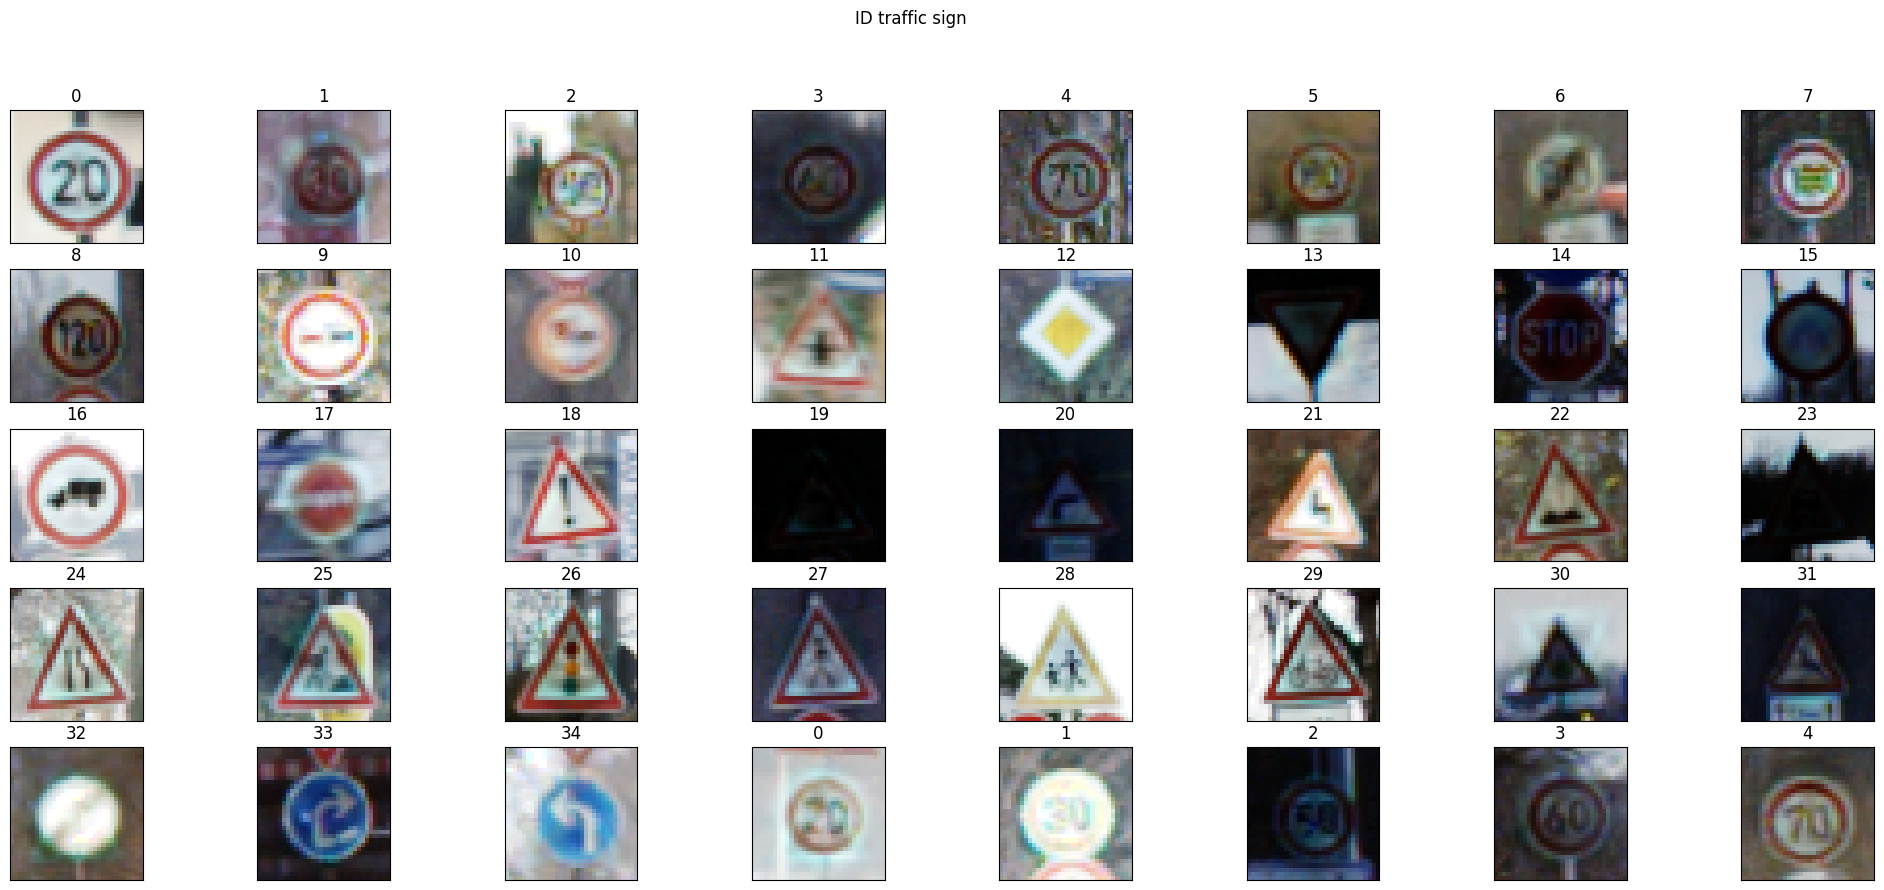

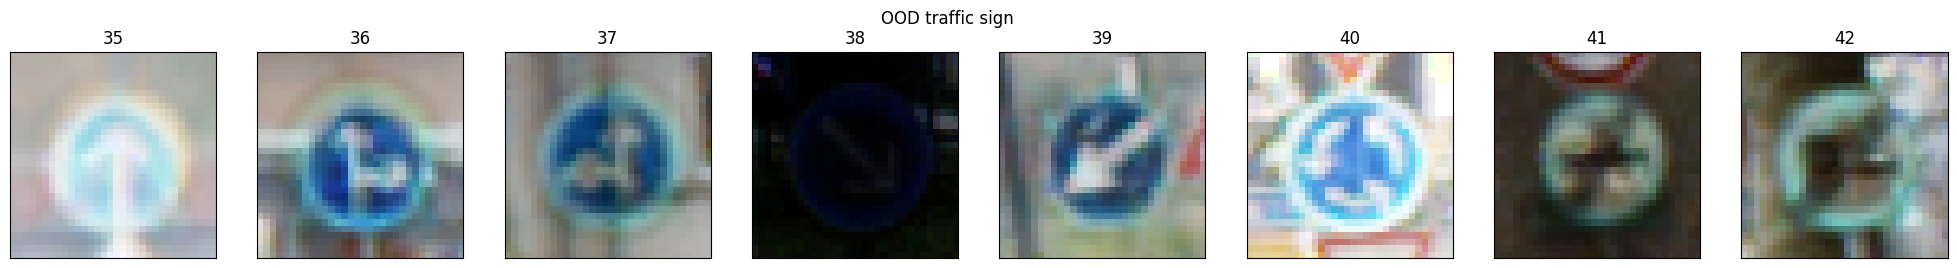

In [8]:
fig_ID, ax_array_ID = plt.subplots(5, 8, figsize=(25, 10))
fig_OOD, ax_array_OOD = plt.subplots(1, 8, figsize=(25, 3))
for i, ax in enumerate(ax_array_ID.flatten()):
    class_id = i%class_thres
    X_train_in_class = X_train_norm[y_train==class_id]
    ax.imshow(X_train_in_class[i])
    ax.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
    ax.set_title(class_id)
for i, ax in enumerate(ax_array_OOD.flatten()):
    class_id = i%(n_classes-class_thres)+class_thres
    X_train_in_class = X_train_norm[y_train==class_id]
    ax.imshow(X_train_in_class[i])
    ax.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
    ax.set_title(class_id)
fig_ID.suptitle("ID traffic sign")
fig_ID.savefig("./docs/traffic_sign_ID.jpg", dpi=fig.dpi)
fig_OOD.suptitle("OOD traffic sign")
fig_OOD.savefig("./docs/traffic_sign_OOD.jpg", dpi=fig.dpi)
plt.show()


# Step 3: Model Design

### Model Architecture

In [9]:
# import keras
# import keras.backend as K
from keras import regularizers
from keras.initializers import TruncatedNormal
from keras.models import Sequential
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization
import keras.backend as K
import keras_uncertainty as ku
from keras_uncertainty.layers import StochasticDropout, VariationalConv2D, VariationalDense, FlipoutConv2D, FlipoutDense
# from keras_uncertainty.layers import DropConnectConv2D, DropConnectDense
# from utils import DropConnectConv2D, DropConnectDense
# it seems that the variational inference in keras_uncertainty is not updated any more, so I use tensorflow_probability here
import tensorflow_probability as tfp
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
tfn = tfp.experimental.nn


2024-02-27 22:31:57.314452: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 22:31:57.314480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 22:31:57.315412: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 22:31:57.320304: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-27 22:31:57.918506: W tensorflow/comp

In [10]:
keep_prob = 0.5
mu = 0
sigma = 0.1
model_frequentist = Sequential(
    name="frequentist",
    layers=[
    # layer1
    Conv2D(filters=64, kernel_size=3, strides=(1,1), padding="SAME", activation="relu", input_shape=(32, 32, 3), kernel_initializer=TruncatedNormal(mean=mu, stddev=sigma)),
    MaxPooling2D((2,2), strides=(2,2), padding="SAME"),
    Dropout(1-keep_prob),
    # layer2
    Conv2D(filters=128, kernel_size=3, strides=(1,1), padding="SAME", activation="relu", kernel_initializer=TruncatedNormal(mean=mu, stddev=sigma)),
    MaxPooling2D((2,2), strides=(2,2), padding="SAME"),
    Dropout(1-keep_prob),
    Flatten(),
    # layer3
    Dense(units=128, activation="relu", kernel_initializer=TruncatedNormal(mean=mu, stddev=sigma)),
    Dropout(1-keep_prob),
    # layer4
    Dense(units=43, kernel_initializer=TruncatedNormal(mean=mu, stddev=sigma)),
    Activation("softmax")
])

model_dropout = Sequential(
    name="dropout",
    layers=[
    # layer1
    Conv2D(filters=64, kernel_size=3, strides=(1,1), padding="SAME", activation="relu", input_shape=(32, 32, 3), kernel_initializer=TruncatedNormal(mean=mu, stddev=sigma)),
    MaxPooling2D((2,2), strides=(2,2), padding="SAME"),
    StochasticDropout(1-keep_prob),
    # layer2
    Conv2D(filters=128, kernel_size=3, strides=(1,1), padding="SAME", activation="relu", kernel_initializer=TruncatedNormal(mean=mu, stddev=sigma)),
    MaxPooling2D((2,2), strides=(2,2), padding="SAME"),
    StochasticDropout(1-keep_prob),
    Flatten(),
    # layer3
    Dense(units=128, activation="relu", kernel_initializer=TruncatedNormal(mean=mu, stddev=sigma)),
    StochasticDropout(1-keep_prob),
    # layer4
    Dense(units=43, kernel_initializer=TruncatedNormal(mean=mu, stddev=sigma)),
    Activation("softmax")
])

# model_dropconnect = Sequential(
#     name="dropconnect",
#     layers=[
#     # layer1
#     DropConnectConv2D(filters=64, kernel_size=3, strides=(1,1), padding="SAME", activation="relu", prob=1-keep_prob, input_shape=(32, 32, 3), kernel_initializer=TruncatedNormal(mean=mu, stddev=sigma)),
#     MaxPooling2D((2,2), strides=(2,2), padding="SAME"),
#     # layer2
#     DropConnectConv2D(filters=128, kernel_size=3, strides=(1,1), padding="SAME", activation="relu", prob=1-keep_prob, kernel_initializer=TruncatedNormal(mean=mu, stddev=sigma)),
#     MaxPooling2D((2,2), strides=(2,2), padding="SAME"),
#     Flatten(),
#     # layer3
#     DropConnectDense(units=128, prob=1-keep_prob, activation="relu", kernel_initializer=TruncatedNormal(mean=mu, stddev=sigma)),
#     # layer4
#     Dense(units=43, kernel_initializer=TruncatedNormal(mean=mu, stddev=sigma)),
#     Activation("softmax")
# ])

model_ensemble = Sequential(
    name="ensemble",
    layers=[
    # layer1
    Conv2D(filters=64, kernel_size=3, strides=(1,1), padding="SAME", activation="relu", input_shape=(32, 32, 3), kernel_initializer=TruncatedNormal(mean=mu, stddev=sigma)),
    MaxPooling2D((2,2), strides=(2,2), padding="SAME"),
    Dropout(1-keep_prob),
    # layer2
    Conv2D(filters=128, kernel_size=3, strides=(1,1), padding="SAME", activation="relu", kernel_initializer=TruncatedNormal(mean=mu, stddev=sigma)),
    MaxPooling2D((2,2), strides=(2,2), padding="SAME"),
    Dropout(1-keep_prob),
    Flatten(),
    # layer3
    Dense(units=128, activation="relu", kernel_initializer=TruncatedNormal(mean=mu, stddev=sigma)),
    Dropout(1-keep_prob),
    # layer4
    Dense(units=43, kernel_initializer=TruncatedNormal(mean=mu, stddev=sigma)),
    Activation("softmax")
])

# model_vi = Sequential(
#     name="vi",
#     layers=[
#     # layer1
#     VariationalConv2D(filters=64, kernel_size=3, kl_weight=0.5 ,strides=(1,1), padding="SAME", activation="relu", input_shape=(32, 32, 3)),
#     MaxPooling2D((2,2), strides=(2,2), padding="SAME"),
#     Dropout(1-keep_prob),
#     # layer2
#     VariationalConv2D(filters=128, kernel_size=3, kl_weight=0.5 ,strides=(1,1), padding="SAME", activation="relu"),
#     MaxPooling2D((2,2), strides=(2,2), padding="SAME"),
#     Dropout(1-keep_prob),
#     Flatten(),
#     # layer3
#     VariationalDense(units=128, kl_weight=0.5 ,activation="relu"),
#     Dropout(1-keep_prob),
#     # layer4
#     VariationalDense(units=43, kl_weight=0.5),
#     Activation("softmax")
# ])

divergence_fn = lambda q, p, ignore: tfp.distributions.kl_divergence(q, p)/X_train_ID.shape[0]
model_flipout = Sequential(
    name="flipout",
    layers=[
    # layer1
    tfp.layers.Convolution2DFlipout(filters=64, kernel_size=3, strides=(1,1), padding="SAME", activation="relu", input_shape=(32, 32, 3), kernel_divergence_fn=divergence_fn, bias_divergence_fn=divergence_fn),
    # BatchNormalization(),
    # Activation("relu"),
    MaxPooling2D((2,2), strides=(2,2), padding="SAME"),
    # Dropout(1-keep_prob),
    # layer2
    tfp.layers.Convolution2DFlipout(filters=128, kernel_size=3, strides=(1,1), padding="SAME", activation="relu", kernel_divergence_fn=divergence_fn, bias_divergence_fn=divergence_fn),
    # BatchNormalization(),
    # Activation("relu"),
    MaxPooling2D((2,2), strides=(2,2), padding="SAME"),
    # Dropout(1-keep_prob),
    Flatten(),
    # layer3
    tfp.layers.DenseFlipout(units=128, activation="relu", kernel_divergence_fn=divergence_fn, bias_divergence_fn=divergence_fn),
    # BatchNormalization(),
    # Activation("relu"),
    # Dropout(1-keep_prob),
    # layer4
    tfp.layers.DenseFlipout(units=43, kernel_divergence_fn=divergence_fn, bias_divergence_fn=divergence_fn),
    Activation("softmax")
])
# for layer in model_flipout.layers:
#     layer.kernel_regularizer = regularizers.l1(0.01)

# model_flipout = Sequential(
#     name="flipout",
#     layers=[
#     # layer1
#     tfp.layers.Convolution2DReparameterization(filters=32, kernel_size=5, strides=(1,1), padding="SAME", activation="relu", input_shape=(32, 32, 3)),
#     MaxPooling2D((2,2), strides=(2,2), padding="SAME"),
#     # Dropout(1-keep_prob),
#     # layer2
#     tfp.layers.Convolution2DReparameterization(filters=64, kernel_size=5, strides=(1,1), padding="SAME", activation="relu"),
#     MaxPooling2D((2,2), strides=(2,2), padding="SAME"),
#     # Dropout(1-keep_prob),
#     Flatten(),
#     # layer3
#     tfp.layers.DenseFlipout(units=1024, activation="relu"),
#     Dropout(1-keep_prob),
#     # layer4
#     tfp.layers.DenseFlipout(units=43),
#     # Activation("softmax")
# ])
# num_batches = X_train_ID.shape[0]/256 
# model_flipout = Sequential(
#     name="flipout",
#     layers=[
#     # layer1
#     FlipoutConv2D(filters=64, kernel_size=3, kl_weight=1/num_batches, strides=(1,1), padding="SAME", activation="relu", input_shape=(32, 32, 3)),
#     MaxPooling2D((2,2), strides=(2,2), padding="SAME"),
#     Dropout(1-keep_prob),
#     # layer2
#     FlipoutConv2D(filters=128, kernel_size=3, kl_weight=1/num_batches, strides=(1,1), padding="SAME", activation="relu"),
#     MaxPooling2D((2,2), strides=(2,2), padding="SAME"),
#     Dropout(1-keep_prob),
#     Flatten(),
#     # layer3
#     FlipoutDense(units=128, kl_weight=1/num_batches, activation="relu"),
#     # Dropout(1-keep_prob),
#     # layer4
#     FlipoutDense(units=43, kl_weight=1/num_batches),
#     Activation("softmax")
# ])

2024-02-27 22:31:59.121295: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-02-27 22:31:59.121330: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: cmtcdeu67287670
2024-02-27 22:31:59.121338: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: cmtcdeu67287670
2024-02-27 22:31:59.121454: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 470.223.2
2024-02-27 22:31:59.121475: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 470.223.2
2024-02-27 22:31:59.121481: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 470.223.2
/lhome/yuwewan/.local/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer

In [11]:
from utils import accuracy_prob_models
import tensorflow as tf
from tensorflow import optimizers

def frequentist_pipeline(model, n_epochs = 30, batch_size = 256, n_sample_test = 25):
  model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  model.fit(X_train_ID, y_train_ID, batch_size=batch_size, epochs=n_epochs, validation_data=(X_valid_ID, y_valid_ID), shuffle=True)
  y_pred = model.predict(X_test_ID, batch_size=batch_size)
  acc_test = accuracy_prob_models(y_pred, y_test_ID)
  print("accuracy on test data: ", acc_test)
  model.save(f"models/{model.name}.h5")

def stochastic_pipeline(backbone, n_epochs = 30, batch_size = 256, n_sample_test = 25):
  backbone.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  backbone.fit(X_train_ID, y_train_ID, batch_size=batch_size, epochs=n_epochs, validation_data=(X_valid_ID, y_valid_ID), shuffle=True)
  model = ku.models.StochasticClassifier(backbone)
  y_pred_mean = model.predict(X_test_ID, n_sample_test)
  acc_test = accuracy_prob_models(y_pred_mean, y_test_ID)
  print("accuracy on test data: ", acc_test)
  backbone.save(f"models/{backbone.name}.h5")

def ensemble_pipeline(backbone, n_epochs = 30, batch_size = 256, n_ensembles = 5):
  backbone.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  model = ku.models.DeepEnsembleClassifier(lambda : backbone, n_ensembles)
  model.fit(X_train_ID, y_train_ID, batch_size=batch_size, epochs=n_epochs, validation_data=(X_valid_ID, y_valid_ID), shuffle=True)
  y_pred_mean, y_pred_std = model.predict(X_test_ID, return_std=True)
  acc_test = accuracy_prob_models(y_pred_mean, y_test_ID)
  print("accuracy on test data: ", acc_test)
  model.save("models",f"{backbone.name}_metadata.h5")
  # model.save_weights("models",f"{backbone.name}_weights.h5")

def neg_log_likelihood(y_obs, y_pred):
  dist = tfp.distributions.Categorical(logits=y_pred)
  return -tf.reduce_mean(dist.log_prob(tf.cast(y_obs, dtype=tf.float32)))

def elbo_loss(y_true, logits):
  dist = tfp.distributions.Categorical(logits=logits)
  nlll = -tf.reduce_mean(dist.log_prob(tf.cast(y_true, dtype=tf.float32)))
  mu = K.mean(logits)
  logvar = K.log(K.var(logits))
  kl = -0.5*tf.reduce_mean(1+logvar-K.square(mu)-K.exp(logvar))
  return nlll + kl

def flipout_pipeline(model, n_epochs = 30, batch_size = 256, n_sample_test = 25):
  model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=0.005), metrics=["accuracy"])
  model.fit(X_train_ID, y_train_ID, batch_size=batch_size, epochs=n_epochs, validation_data=(X_valid_ID, y_valid_ID), shuffle=True)
  y_pred = model.predict(X_test_ID)
  acc_test = accuracy_prob_models(y_pred, y_test_ID)
  print("accuracy on test data: ", acc_test)
  model.save_weights(f"models/{model.name}.h5")


# Step 4: Train Model

In [47]:
# train frequentist model
frequentist_pipeline(model_frequentist)

Epoch 1/30
119/119 [==============================] - 11s 89ms/step - loss: 3.8292 - accuracy: 0.0586 - val_loss: 3.4560 - val_accuracy: 0.0729
Epoch 2/30
119/119 [==============================] - 10s 87ms/step - loss: 3.2326 - accuracy: 0.0841 - val_loss: 2.9022 - val_accuracy: 0.2120
Epoch 3/30
119/119 [==============================] - 10s 86ms/step - loss: 2.7755 - accuracy: 0.1912 - val_loss: 2.2983 - val_accuracy: 0.3513
Epoch 4/30
119/119 [==============================] - 10s 84ms/step - loss: 2.3403 - accuracy: 0.2801 - val_loss: 1.8459 - val_accuracy: 0.4635
Epoch 5/30
119/119 [==============================] - 10s 84ms/step - loss: 2.0340 - accuracy: 0.3576 - val_loss: 1.5784 - val_accuracy: 0.5352
Epoch 6/30
119/119 [==============================] - 10s 84ms/step - loss: 1.7583 - accuracy: 0.4367 - val_loss: 1.2957 - val_accuracy: 0.5893
Epoch 7/30
119/119 [==============================] - 10s 85ms/step - loss: 1.4813 - accuracy: 0.5183 - val_loss: 1.0376 - val_accuracy:

/lhome/yuwewan/.local/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
# train dropconnect model
stochastic_pipeline(model_dropout)

Epoch 1/30
119/119 [==============================] - 11s 89ms/step - loss: 3.9536 - accuracy: 0.0636 - val_loss: 3.6772 - val_accuracy: 0.0570
Epoch 2/30
119/119 [==============================] - 10s 88ms/step - loss: 3.4469 - accuracy: 0.0766 - val_loss: 3.2134 - val_accuracy: 0.1096
Epoch 3/30
119/119 [==============================] - 10s 88ms/step - loss: 2.7798 - accuracy: 0.1950 - val_loss: 2.5755 - val_accuracy: 0.2477
Epoch 4/30
119/119 [==============================] - 11s 89ms/step - loss: 2.1157 - accuracy: 0.3448 - val_loss: 2.0716 - val_accuracy: 0.3794
Epoch 5/30
119/119 [==============================] - 11s 89ms/step - loss: 1.7327 - accuracy: 0.4467 - val_loss: 1.8424 - val_accuracy: 0.4242
Epoch 6/30
119/119 [==============================] - 11s 89ms/step - loss: 1.4652 - accuracy: 0.5197 - val_loss: 1.6483 - val_accuracy: 0.4823
Epoch 7/30
119/119 [==============================] - 11s 89ms/step - loss: 1.2564 - accuracy: 0.5850 - val_loss: 1.4832 - val_accuracy:

/lhome/yuwewan/anaconda3/envs/tf2_py39/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
# train ensemble model
ensemble_pipeline(model_ensemble)

Epoch 1/30
119/119 [==============================] - 11s 87ms/step - loss: 3.6867 - accuracy: 0.0612 - val_loss: 3.3284 - val_accuracy: 0.1661
Epoch 2/30
119/119 [==============================] - 11s 90ms/step - loss: 2.8790 - accuracy: 0.1825 - val_loss: 2.2073 - val_accuracy: 0.3786
Epoch 3/30
119/119 [==============================] - 11s 89ms/step - loss: 2.1739 - accuracy: 0.3336 - val_loss: 1.7432 - val_accuracy: 0.4716
Epoch 4/30
119/119 [==============================] - 11s 89ms/step - loss: 1.8114 - accuracy: 0.4263 - val_loss: 1.3551 - val_accuracy: 0.6115
Epoch 5/30
119/119 [==============================] - 10s 86ms/step - loss: 1.5133 - accuracy: 0.5099 - val_loss: 1.0420 - val_accuracy: 0.6859
Epoch 6/30
119/119 [==============================] - 10s 85ms/step - loss: 1.2635 - accuracy: 0.5840 - val_loss: 0.8633 - val_accuracy: 0.7245
Epoch 7/30
119/119 [==============================] - 10s 86ms/step - loss: 1.0817 - accuracy: 0.6416 - val_loss: 0.6730 - val_accuracy:

In [12]:
# train flipout model
flipout_pipeline(model_flipout)

Epoch 1/30
119/119 [==============================] - 21s 165ms/step - loss: 89.0594 - accuracy: 0.1490 - val_loss: 78.6342 - val_accuracy: 0.4000
Epoch 2/30
119/119 [==============================] - 19s 160ms/step - loss: 68.6602 - accuracy: 0.6544 - val_loss: 59.4482 - val_accuracy: 0.7182
Epoch 3/30
119/119 [==============================] - 19s 160ms/step - loss: 50.5043 - accuracy: 0.8689 - val_loss: 42.5313 - val_accuracy: 0.7956
Epoch 4/30
119/119 [==============================] - 19s 160ms/step - loss: 34.7673 - accuracy: 0.9160 - val_loss: 28.3378 - val_accuracy: 0.8109
Epoch 5/30
119/119 [==============================] - 19s 161ms/step - loss: 22.1945 - accuracy: 0.9389 - val_loss: 17.6371 - val_accuracy: 0.8242
Epoch 6/30
119/119 [==============================] - 19s 160ms/step - loss: 13.4503 - accuracy: 0.9464 - val_loss: 10.7948 - val_accuracy: 0.8388
Epoch 7/30
119/119 [==============================] - 19s 161ms/step - loss: 8.2530 - accuracy: 0.9469 - val_loss: 7.1

# Step 5: Calibration

In [12]:
from keras.models import load_model
from utils import reliability_vector, reliability_plot
load_model_ku = ku.backend.models.load_model

def expected_calibration_error(y_conf, y_acc, n_bins=10):

    bin_sizes = np.histogram(y_conf, bins=n_bins, range=(0,1))[0]
    return np.sum(bin_sizes * np.abs(np.nan_to_num(y_acc)-y_conf))/np.sum(bin_sizes)


345/345 [==============================] - 2s 6ms/step
expected calibration error of model frequentist :  0.13786539879384777


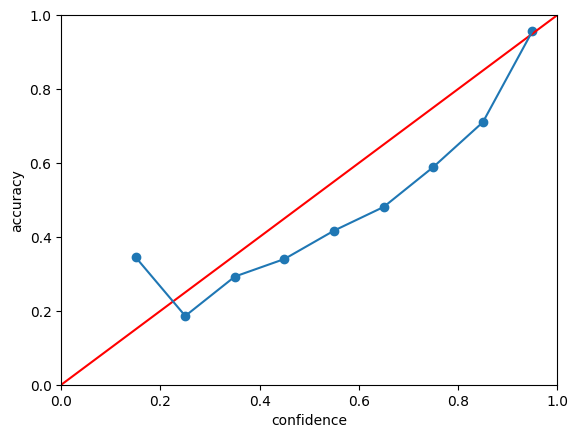

345/345 [==============================] - 3s 7ms/step
expected calibration error of model dropout :  0.22794344155759969


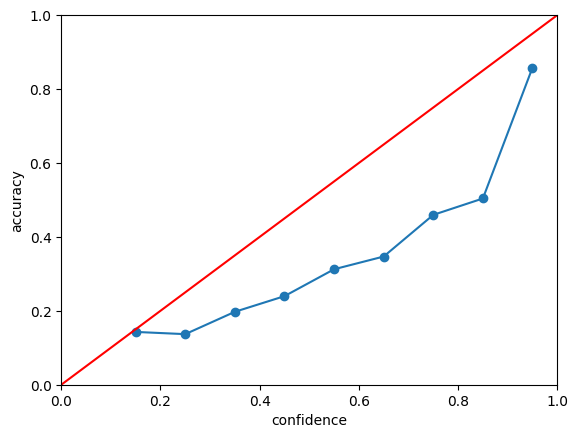

345/345 [==============================] - 2s 6ms/step
expected calibration error of model ensemble :  0.20988318143033421


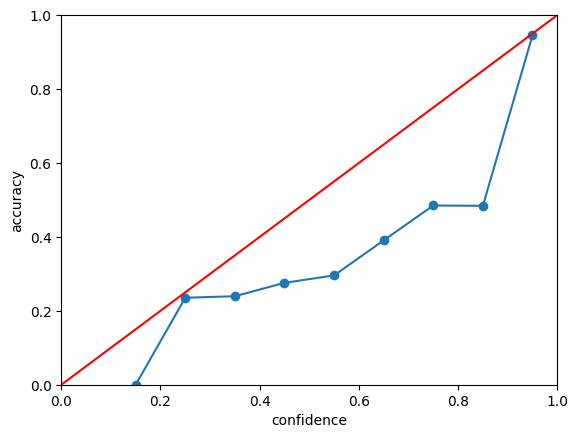

345/345 [==============================] - 3s 9ms/step
expected calibration error of model flipout :  0.24676901783607694


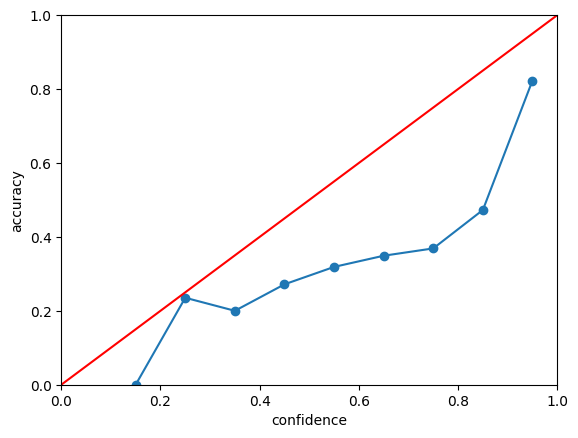

In [13]:
import keras

custom_objects = {"StochasticDropout": StochasticDropout, "Conv2DFlipout": tfp.layers.conv_variational.Conv2DFlipout}
models = []
model_names = []  
with keras.saving.custom_object_scope(custom_objects):
    models.append(load_model("./models/frequentist.h5"))
    model_names.append("frequentist")
    models.append(load_model_ku("./models/dropout.h5"))
    model_names.append("dropout")
    models.append(load_model("./models/ensemble_metadata.h5"))
    model_names.append("ensemble")
    model_flipout.load_weights("./models/flipout.h5")
    models.append(model_flipout)
    model_names.append("flipout")


for i in range(len(models)):
    y_pred_ID = models[i].predict(X_test_ID)
    acc, bins_cutoffs = reliability_vector(y_pred_ID, y_test_ID, n_bins=10)
    ece = expected_calibration_error(bins_cutoffs, acc)
    print(f"expected calibration error of model {model_names[i]} : ", ece)
    reliability_plot(acc, bins_cutoffs)




### comments on reliability
it seems that all four models(frequentist, dropout, ensemble and flipout) are overestimated. frequentist model has lowest ece error, the other three models has ece error between 20% and 30%


# Step 6 OOD detection

18/18 [==============================] - 0s 10ms/step


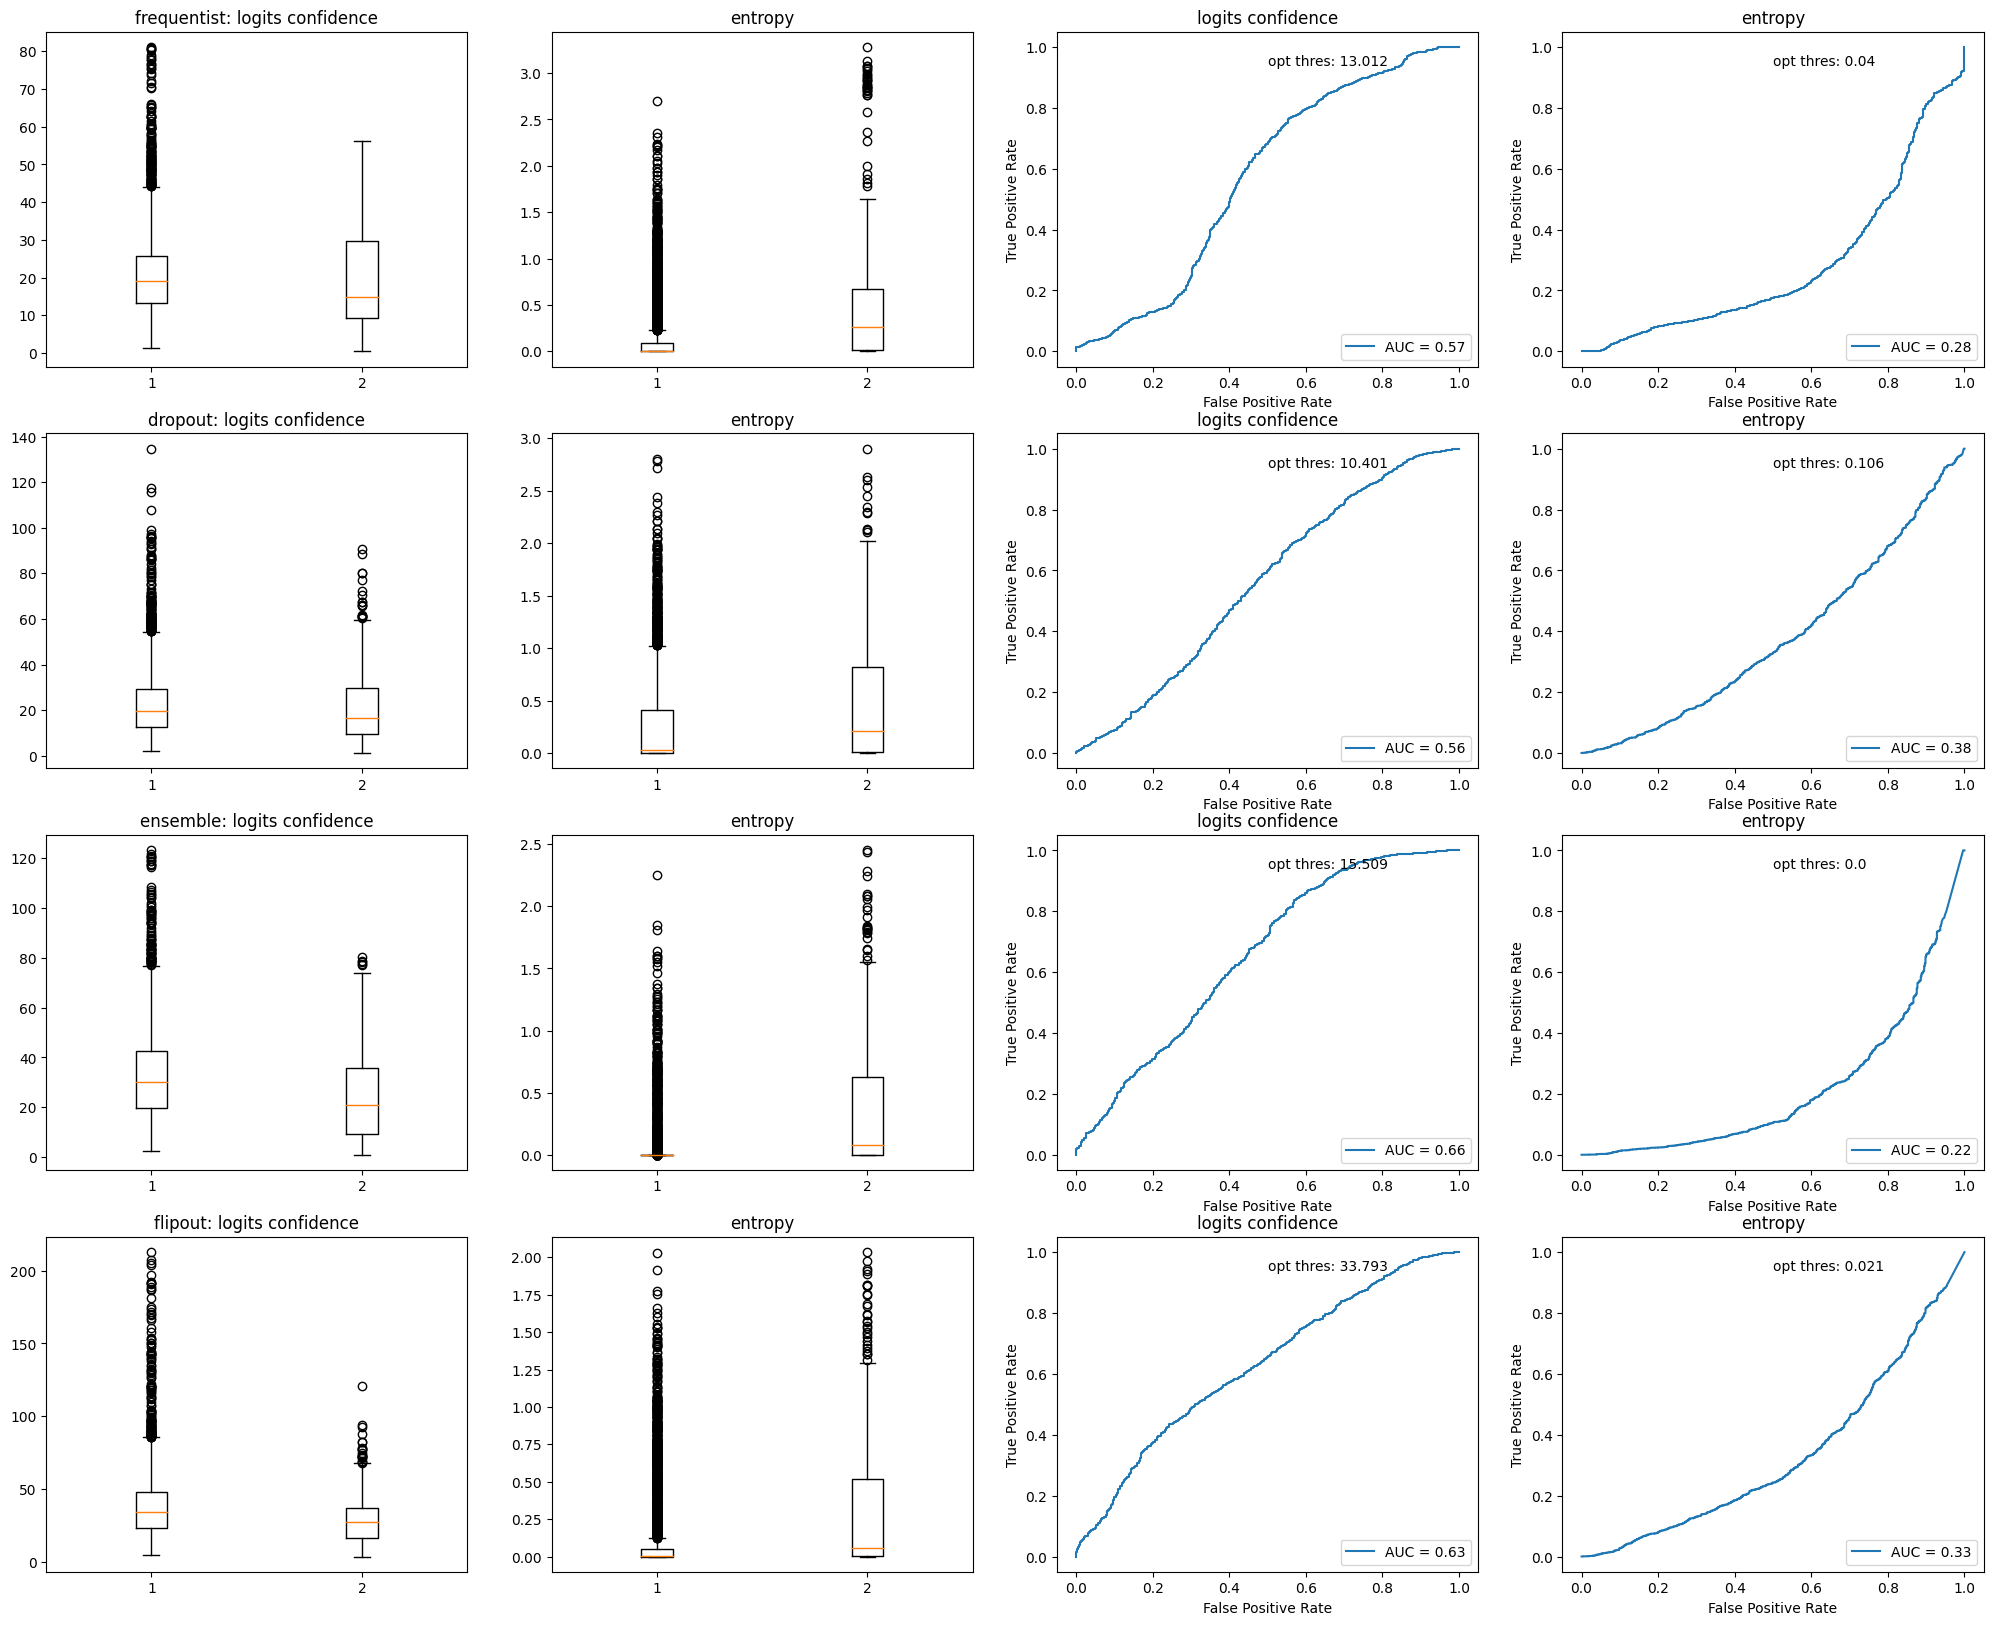

In [40]:
from utils import ood_detection_scores, plot_roc
from keras_uncertainty.utils import numpy_entropy

fig, ax_array = plt.subplots(len(models), 4, figsize=(25, 20))
for i in range(len(models)):
    y_pred_ID = models[i].predict(X_valid_ID)
    y_pred_OOD = models[i].predict(X_valid_OOD)
    # acc_test_ID = accuracy_prob_models(y_pred_ID, y_test_ID)
    # acc_test_OOD = accuracy_prob_models(y_pred_OOD, y_test_OOD)
    # print("accuracy on ID test data: ", acc_test_ID)
    # print("accuracy on OOD test data: ", acc_test_OOD)
    pre_softmax_extractor = keras.Model(
        inputs=models[i].inputs,
        outputs=models[i].layers[-2].output
    )
    y_pred_ID_logits = pre_softmax_extractor(X_valid_ID)
    y_pred_OOD_logits = pre_softmax_extractor(X_valid_OOD)
    y_pred_ID_confidence = tf.reduce_max(y_pred_ID_logits, axis=1)
    y_pred_OOD_confidence = tf.reduce_max(y_pred_OOD_logits, axis=1)
    y_pred_ID_entropy = numpy_entropy(y_pred_ID, axis=-1)
    y_pred_OOD_entropy = numpy_entropy(y_pred_OOD, axis=-1)
    # remove nan
    y_pred_ID_entropy = y_pred_ID_entropy[~np.isnan(y_pred_ID_entropy)]
    y_pred_OOD_entropy = y_pred_OOD_entropy[~np.isnan(y_pred_OOD_entropy)]
    # display(ood_detection_scores(y_pred_ID_confidence, y_pred_OOD_confidence, min_thresh=0.0, max_thresh=150))
    # display(ood_detection_scores(y_pred_ID_entropy, y_pred_OOD_entropy, min_thresh=0.0, max_thresh=4.0))
    _ = ax_array[i][0].boxplot([y_pred_ID_confidence, y_pred_OOD_confidence], )
    _ = ax_array[i][1].boxplot([y_pred_ID_entropy, y_pred_OOD_entropy])
    ax_array[i][0].set_title(f"{models[i].name}: logits confidence")
    ax_array[i][1].set_title("entropy")
    plot_roc(y_pred_ID_confidence, y_pred_OOD_confidence, ax_array[i][2])
    plot_roc(y_pred_ID_entropy, y_pred_OOD_entropy, ax_array[i][3])
    ax_array[i][2].set_title("logits confidence")
    ax_array[i][3].set_title("entropy")
    

In [30]:
i=0 # choosing frequentist model
y_pred_ID = models[i].predict(X_valid_ID)
y_pred_OOD = models[i].predict(X_valid_OOD)
y_pred_ID_entropy = numpy_entropy(y_pred_ID, axis=-1)
y_pred_OOD_entropy = numpy_entropy(y_pred_OOD, axis=-1)
# remove nan
y_pred_ID_entropy = y_pred_ID_entropy[~np.isnan(y_pred_ID_entropy)]
y_pred_OOD_entropy = y_pred_OOD_entropy[~np.isnan(y_pred_OOD_entropy)]
display(ood_detection_scores(y_pred_ID_entropy, y_pred_OOD_entropy, min_thresh=0.0, max_thresh=4.0))

18/18 [==============================] - 0s 6ms/step


,threshold,accuracy,accuracy_id,accuracy_ood,true_positive_rate,f1_score
0,0.00,0.751474,0.853125,0.066667,0.066667,0.064846
1,0.04,0.307710,0.306510,0.315789,0.315789,0.105479
2,0.08,0.272109,0.257292,0.371930,0.371930,0.116676
3,0.12,0.254195,0.232813,0.398246,0.398246,0.121293
4,0.16,0.240136,0.214323,0.414035,0.414035,0.123463
...,...,...,...,...,...,...
96,3.84,0.129252,0.000000,1.000000,1.000000,0.228916
97,3.88,0.129252,0.000000,1.000000,1.000000,0.228916
98,3.92,0.129252,0.000000,1.000000,1.000000,0.228916
99,3.96,0.129252,0.000000,1.000000,1.000000,0.228916


### comments on odd detection
from above plots we can see that entropy is a better indicator to seperate ID and OOD data, as AUC of entropy is farther away from 0.5 and distribution shows more difference on ID and ODD data. 
with elbow method I will choose threshold=0.04 (TPR = 0.3 and FPR = 0.7) for seperation of ID and ODD data


In [44]:
# ood detection on test data
i=0 # choosing frequentist model
y_pred_ID = models[i].predict(X_test_ID)
y_pred_OOD = models[i].predict(X_test_OOD)
y_pred_ID_entropy = numpy_entropy(y_pred_ID, axis=-1)
y_pred_OOD_entropy = numpy_entropy(y_pred_OOD, axis=-1)
# remove nan
y_pred_ID_entropy = y_pred_ID_entropy[~np.isnan(y_pred_ID_entropy)]
y_pred_OOD_entropy = y_pred_OOD_entropy[~np.isnan(y_pred_OOD_entropy)]
display(ood_detection_scores(y_pred_OOD_entropy, y_pred_ID_entropy, min_thresh=0.0, max_thresh=4.0)) # revert ID and ODD data

50/50 [==============================] - 0s 7ms/step


,threshold,accuracy,accuracy_id,accuracy_ood,true_positive_rate,f1_score
0,0.00,0.229295,0.854088,0.139312,0.139312,0.240125
1,0.04,0.489074,0.495597,0.488134,0.488134,0.625501
2,0.08,0.523832,0.442767,0.535507,0.535507,0.662855
3,0.12,0.549010,0.418239,0.567844,0.567844,0.687617
4,0.16,0.565954,0.389937,0.591304,0.591304,0.704283
...,...,...,...,...,...,...
96,3.84,0.874109,0.000000,1.000000,1.000000,0.932826
97,3.88,0.874109,0.000000,1.000000,1.000000,0.932826
98,3.92,0.874109,0.000000,1.000000,1.000000,0.932826
99,3.96,0.874109,0.000000,1.000000,1.000000,0.932826


### comment on ood detection on test data
by using the seclected threshold we could get a f1 score on 0.625, which is a satisfactory indicator of odd detection.
the accuracy of ID detection on test data is increased below threshold compared with validation data.